In [1]:
import pandas as pd
import ftplib
import isd_parse
import gzip
import io

In [2]:
ftp = ftplib.FTP('ftp.ncdc.noaa.gov')
ftp.login()

'230-****** WARNING ** WARNING ** WARNING ** WARNING ** WARNING ******\n ** This is a United States Department of Commerce computer     **\n ** system, which may be accessed and used only for             **\n ** official Government business by authorized personnel.       **\n ** Unauthorized access or use of this computer system may      **\n ** subject violators to criminal, civil, and/or administrative **\n ** action.  All information on this computer system may be     **\n ** intercepted, recorded, read, copied, and disclosed by and   **\n ** to authorized personnel for official purposes, including    **\n ** criminal investigations.  Access or use of this computer    **\n ** system by any person, whether authorized or unauthorized,   **\n ** constitutes consent to these terms.                         **\n ****** WARNING ** WARNING ** WARNING ** WARNING ** WARNING ******\n230 Anonymous access granted, restrictions apply'

In [3]:
def get_file(ftp, fname):
    result = bytes()
    def append_to_bytes(bs):
        nonlocal result
        result += bs
    ftp.retrbinary('RETR {}'.format(fname), append_to_bytes)
    return result

In [4]:
ftp.cwd('/pub/data/noaa/')
isd_history = get_file(ftp, 'isd-history.csv')

In [15]:
with io.StringIO(isd_history.decode()) as f:
    stations_df = pd.read_csv(f, dtype={"USAF": str, "WBAN": str, "LAT": float, "LON": float})
print(stations_df.shape)
stations_df.head()

(29744, 11)


,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
0,007018,99999,WXPOD 7018,NaN,NaN,NaN,0.00,0.000,7018.0,20110309,20130730
1,007026,99999,WXPOD 7026,AF,NaN,NaN,0.00,0.000,7026.0,20120713,20170822
2,007070,99999,WXPOD 7070,AF,NaN,NaN,0.00,0.000,7070.0,20140923,20150926
3,008260,99999,WXPOD8270,NaN,NaN,NaN,0.00,0.000,0.0,20050101,20100920
4,008268,99999,WXPOD8278,AF,NaN,NaN,32.95,65.567,1156.7,20100519,20120323


In [16]:
MIN_LAT, MAX_LAT = 32.4, 33.6
MIN_LONG, MAX_LONG = -118, -116
mask = ((stations_df.LAT >= MIN_LAT)
         & (stations_df.LAT <= MAX_LAT)
         & (stations_df.LON >= MIN_LONG)
         & (stations_df.LON <= MAX_LONG))
print(stations_df[mask].shape)
stations_df[mask].head()

(58, 11)


,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
18777,722859,99999,DANA POINT,US,CA,NaN,33.450,-117.680,15.0,19840607,19960630
18813,722900,23188,SAN DIEGO INTERNATIONAL AIRPORT,US,CA,KSAN,32.734,-117.183,4.6,19420101,20200213
18814,722901,99999,SAN DIEGO/MONTGOMER,US,CA,NaN,32.817,-117.133,129.0,19730101,19900206
18815,722903,03131,MONTGOMERY FIELD AIRPORT,US,CA,KMYF,32.816,-117.139,127.1,20060101,20200213
18816,722903,99999,MONTGOMERY FLD,US,CA,KMYF,32.816,-117.140,130.0,19900208,20051231


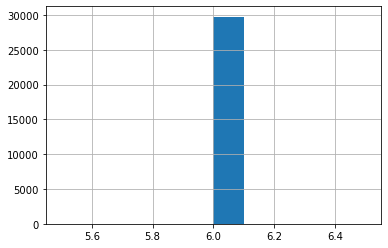

In [17]:
stations_df.USAF.str.len().hist()

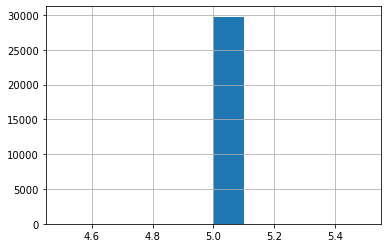

In [18]:
stations_df.WBAN.str.len().hist()

In [20]:
ids = stations_df[mask].USAF.astype(str) \
        + "-" + stations_df[mask].WBAN.str.pad(width=5, side='left', fillchar='0')
ids.head()

18777    722859-99999
18813    722900-23188
18814    722901-99999
18815    722903-03131
18816    722903-99999
dtype: object

In [21]:
from tqdm.notebook import tqdm
import numpy as np
ftp = ftplib.FTP('ftp.ncdc.noaa.gov')
ftp.login()
files = []
for year in tqdm(range(2000, 2021)):
    root = '/pub/data/noaa/{}/'.format(year)
    ftp.cwd(root)
    files.extend([root + f for f in ftp.nlst()])
print(len(files))
print(np.random.choice(files, size=10))


262525
['/pub/data/noaa/2002/011030-99999-2002.gz'
 '/pub/data/noaa/2002/113570-99999-2002.gz'
 '/pub/data/noaa/2014/245850-99999-2014.gz'
 '/pub/data/noaa/2011/720962-00337-2011.gz'
 '/pub/data/noaa/2006/837780-99999-2006.gz'
 '/pub/data/noaa/2016/655990-99999-2016.gz'
 '/pub/data/noaa/2013/167263-99999-2013.gz'
 '/pub/data/noaa/2020/115020-99999-2020.gz'
 '/pub/data/noaa/2009/835500-99999-2009.gz'
 '/pub/data/noaa/2009/037100-99999-2009.gz']


In [22]:
import os
ca_files = [fn for fn in files if os.path.basename(fn)[:12] in ids.values]
print(np.random.choice(ca_files, size=10))

['/pub/data/noaa/2004/722927-99999-2004.gz'
 '/pub/data/noaa/2018/722909-93115-2018.gz'
 '/pub/data/noaa/2016/722907-53143-2016.gz'
 '/pub/data/noaa/2015/999999-53151-2015.gz'
 '/pub/data/noaa/2003/760013-99999-2003.gz'
 '/pub/data/noaa/2012/722927-03177-2012.gz'
 '/pub/data/noaa/2017/722904-03178-2017.gz'
 '/pub/data/noaa/2011/760013-99999-2011.gz'
 '/pub/data/noaa/2001/722904-99999-2001.gz'
 '/pub/data/noaa/2008/994018-99999-2008.gz']


In [23]:
%%time
ftp = ftplib.FTP('ftp.ncdc.noaa.gov')
ftp.login()
raw_files = [get_file(ftp, fname) for fname in ca_files]

Wall time: 17min 30s


In [24]:
%%time
raw_files = [gzip.decompress(f) for f in raw_files]

Wall time: 4.93 s


In [25]:
%%time
df = pd.DataFrame(data=[isd_parse.parse_isd_line(line)
                        for rf in raw_files
                        for line in rf.decode('ascii').split("\n") if line])

Wall time: 1min 39s


In [26]:
print(df.shape)
df.head()

(4581077, 11)


,var_data_len,usaf_station_id,wban_station_id,date,latitude,longitude,report_type,elevation_meters,call_letters,qc_process,air_temp_c
0,71,722903,99999,2000-01-01 00:00:00,32.817,-117.133,NSRDB,129.0,None,V02,NaN
1,145,722903,99999,2000-01-01 00:53:00,32.820,-117.130,FM-15,129.0,KMYF,V02,12.0
2,71,722903,99999,2000-01-01 01:00:00,32.817,-117.133,NSRDB,129.0,None,V02,NaN
3,213,722903,99999,2000-01-01 01:53:00,32.820,-117.130,FM-15,129.0,KMYF,V02,12.0
4,54,722903,99999,2000-01-01 02:00:00,32.817,-117.133,NSRDB,129.0,None,V02,NaN


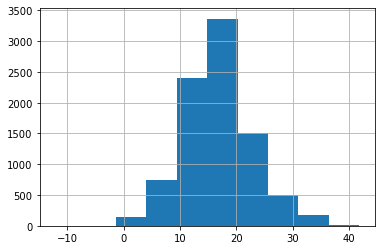

In [27]:
%matplotlib inline
df.sample(10000).air_temp_c.hist()

In [ ]:
%%time
df.to_parquet('noaa_isd_data_SD_2000_to_2020.parquet.gzip',
              compression='gzip')  